# Kats 202 - Detection with Kats

This tutorial will introduce detection in Kats, including change point detection, outlier detection, and trend detection.  It is a more detailed and in-depth introduction than the one provided in Kats 101.  The table of contents for Kats 202 is as follows:

1. Changepoint Detection      
    1.1 CUSUMDetector      
    1.2 BOCPDetector      
    1.3 RobustStatDetector      
    1.4 Comparing the Changepoint Detectors      
2. Outlier Detection      
    2.1 OutlierDetector      
    2.2 MultivariateAnomalyDetector      
3. Trend Detection      
    3.1 MKDetector      
    

**Note:** We provide two types of tutorial notebooks

* **Kats 101**, basic data structure and functionalities in Kats    
* **Kats 20x**, advanced topics, such as advanced forecasting techniques (meta-learning, global model, etc.), advanced detection algorithms (Bayesian online change point detection algorithms, etc), and more.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from imp import reload
from datetime import datetime, timedelta
import sys
sys.path.append("../")

from kats.consts import TimeSeriesData
reload(logging)

<module 'logging' from '/usr/local/Cellar/python@3.7/3.7.10_3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/logging/__init__.py'>

# 1. Changepoint Detection <a class="anchor" id="kats_basics"></a>

Changepoint detection tries to identify times when the probability distribution of a stochastic process or time series changes, e.g. the change of mean in a time series. It is one of the most popular detection tasks in time series analysis. 

## **1.1 `CUSUMDetector`**


CUSUM is a method to detect an up/down shift of means in a time series. Our implementation has two main steps:


1. **Locate the change point:** This is an iterative process where we initialize a change point (in the middle of the time series) and CUSUM time series based on this change point. The next changepoint is the location where the previous CUSUM time series is maximized (or minimized). This iteration continues until either 1) a stable changepoint is found or 2) we exceed the limit number of iterations.
2. **Test the change point for statistical significance:** Conduct log likelihood ratio test to test if the mean of the time series changes at the changepoint calculated in Step 1. The null hypothesis is that there is no change in mean.

By default, we report a detected changepoint if and only if we reject the null hypothesis in Step 2.  If we want to see all the changepoints, we can use the `return_all_changepoints` parameter in `CUSUMDetector` and set it to `True`.

Here are a few additional points worth mentioning:

* We assume there is at most one increase change point and at most one decrease change point. You can use the `change_directions` argument in the detector to specify whether you are looking an increase, a decrease, or both (default is both).
* We use Gaussian distribution as the underlying model to calculate the CUSUM time series value and conduct the hypothesis test.


The full set of parameters for the `detector` method in `CUSUMDetector`, all of which are optional and have default values, are as follows: 
* **threshold**: float, significance level;
* **max_iter**: int, maximum iteration in finding the changepoint;
* **delta_std_ratio**: float, the mean delta has to be larger than this parameter times std of the data to be considered as a change;
* **min_abs_change**: int, minimal absolute delta between mu0 and mu1
* **start_point**: int, the start idx of the changepoint, None means the middle of the time series;
* **change_directions**: list\[str], a list contain either or both 'increase' and 'decrease' to specify what type of change to be detected;
* **interest_window**: list\[int, int], a list containing the start and end of the interest window where we will look for a change point. Note that the llr will still be calculated using all data points;
* **magnitude_quantile**: float, the quantile for magnitude comparison, if none, will skip the magnitude comparison;
* **magnitude_ratio**: float, comparable ratio;
* **magnitude_comparable_day**: float, maximal percentage of days can have comparable magnitude to be considered as regression;
* **return_all_changepoints**: bool, return all the changepoints found, even the insignificant ones.

### Review Basic Usage

We begin by reviewing the basic usage of `CUSUMDetector` from the Kats 101 tutorial.  This simple example is the same one we first introduced there.

In [2]:
# import packages
from kats.detectors.cusum_detection import CUSUMDetector

# synthesize data with simulation
np.random.seed(10)
df_increase_decrease = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', periods=60),
        'increase':np.concatenate([np.random.normal(1,0.2,30), np.random.normal(2,0.2,30)]),
        'decrease':np.concatenate([np.random.normal(1,0.3,50), np.random.normal(0.5,0.3,10)]),
    }
)

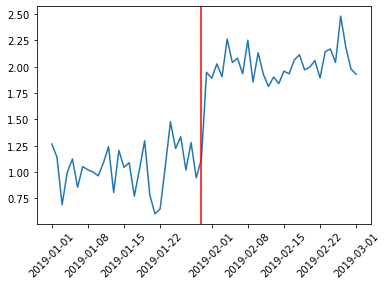

In [3]:
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(change_directions=["increase"])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

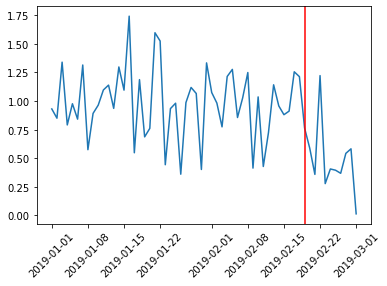

In [4]:
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','decrease']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(change_directions=["decrease"])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

### Interpret the result

If we do not specify which change directions we are looking for using the `change_directions` parameter, `CUSUMDetector` will look for both increases and decreases. In the case below where there is only an increase, it will detect that increase.

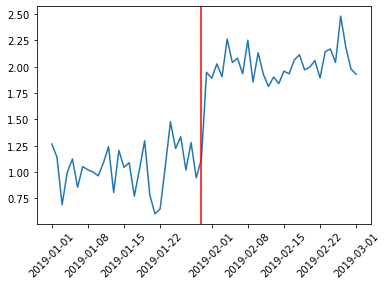

In [5]:
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector()

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

Let's take a look at how we can interpret the results of the `CUSUMDetector`.  The return type of the `detector` method is `List[Tuple[TimeSeriesChangePoint, CUSUMMetadata]]`. Most `detector` methods in Kats return this same structure, but each will have a different metadata object with metadata specific to that detector.

In [6]:
# Get the change point and metadata, since we only detected one change point 
# We can access it with change_points[0] because we only found one change point above
change_point, metadata = change_points[0]
change_point

TimeSeriesChangePoint(start_time: 2019-01-30 00:00:00, end_time: 2019-01-30 00:00:00, confidence: 1.0)

Now let's look at the metadata.  Here are the components of the metadata:
* **direction**: str, the change point direction, either 'increase' or 'decrease';
* **cp_index**: int, the index of the change point;
* **mu0**: float, mean before the change point;
* **mu1**: float, mean after the change point;
* **delta**: float, mu1 - mu0;
* **llr_int**: float, the log likelihood ratio in interest window, or `inf` if not using an interet window;
* **llr**: float, the log likelihood ratio for the full time series;
* **regression_detected**: bool, is the change point detected by the algorithm (only relevant when `return_all_changepoints=True`);
* **stable_changepoint**: bool, indicates whether the algorithm converged to this point (rather than hitting the iteration limit);
* **p_value**: float, p-value for the likelihood ratio test;
* **p_value_int**: float, p-value for the likelihood ratio test in interest_window, or `nan` if not using an interest window.

In [7]:
metadata.__dict__

{'_direction': 'increase',
 '_cp_index': 29,
 '_mu0': 1.0395982783530555,
 '_mu1': 2.0233303619383967,
 '_delta': 0.9837320835853411,
 '_llr_int': inf,
 '_llr': 128.93223399207324,
 '_regression_detected': True,
 '_stable_changepoint': True,
 '_p_value': 0.0,
 '_p_value_int': nan}

We will explain interest windows in the next section, but for now, notice that since we are not using the `interet_window` parameter in `CUSUMDetector`, the metadata values of `llr_int` and `p_value_int` are `inf` and `nan` respectively.  These values will be populated properly only when we use the `interet_window` parameter in `CUSUMDetector`.

### Introducing Interest Windows

Sometimes we want to look for a changepoint in a specific window, which we call an interest window and can be specified using the `interest_window` paramter in `CUSUMDetector`.  Here is what the detector essentially does when using an interest window:

1. Do both of the major aforementioned steps of CUSUM (locate the change point and test for signifiance) when only considering the data within the `interest_window`.  By default, continue only if we find a changepoint and reject the null hypothesis.
2. Do an additional test for statistical significance on the changepoint found in step 1 using the entire input time series (not just the restriction to `interest_window`).  By default, return this changepoint only if we reject the null hypothesis (unless we set the parameter `return_all_changepoints` to `True`).

Since the `CUSUMDetector` can only return one change point in each direction, we can use the `interest_window` parameter narrow the search window in the case that the input time series contains multiple change points.  However, the change point point we return must pass the likelihood ratio test for the entire time series (step 2 above) in addition to passing the likelihood ratio test within the interest window (step 1 above).

Let's return to the first example where we used `CUSUMDetector` to detect an increase.  If we set the `interest_window` to a window that contains the change point that we found above, we will find it again.

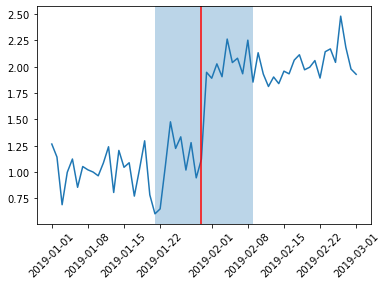

In [8]:
# limit the interest_window between 20th and 40th data point
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(interest_window=[20,40])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

If we set the `interest_window` to a window that does not find any change point, we will return no change point.

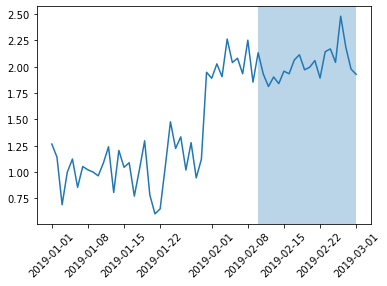

In [9]:
# limit the interest_window to last 20 the datapoint and no change point detected
tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = CUSUMDetector(tsd)
change_points = detector.detector(interest_window=[40,60])

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

### Daily Seasonality with Interest Windows

If we are using an interest window in a time series with seasonality, we can get a false positive.  Here we show how this happens and how we can address the problem.  Let's start by generating a time series with seasonality.

In [10]:
from kats.tests.test_detectors import CUSUMDetectorTest
# synthesize seasonal data with simulation
# def simulate_seasonal_term(
#     periodicity, total_cycles, noise_std=1.0, harmonics=None
# ):
#     duration = periodicity * total_cycles
#     assert duration == int(duration)
#     duration = int(duration)
#     harmonics = harmonics if harmonics else int(np.floor(periodicity / 2))

#     lambda_p = 2 * np.pi / float(periodicity)

#     gamma_jt = noise_std * np.random.randn((harmonics))
#     gamma_star_jt = noise_std * np.random.randn((harmonics))

#     total_timesteps = 100 * duration  # Pad for burn in
#     series = np.zeros(total_timesteps)
#     for t in range(total_timesteps):
#         gamma_jtp1 = np.zeros_like(gamma_jt)
#         gamma_star_jtp1 = np.zeros_like(gamma_star_jt)
#         for j in range(1, harmonics + 1):
#             cos_j = np.cos(lambda_p * j)
#             sin_j = np.sin(lambda_p * j)
#             gamma_jtp1[j - 1] = (
#                 gamma_jt[j - 1] * cos_j
#                 + gamma_star_jt[j - 1] * sin_j
#                 + noise_std * np.random.randn()
#             )
#             gamma_star_jtp1[j - 1] = (
#                 -gamma_jt[j - 1] * sin_j
#                 + gamma_star_jt[j - 1] * cos_j
#                 + noise_std * np.random.randn()
#             )
#         series[t] = np.sum(gamma_jtp1)
#         gamma_jt = gamma_jtp1
#         gamma_star_jt = gamma_star_jtp1
#     wanted_series = series[-duration:]  # Discard burn in

#     return wanted_series

np.random.seed(1)
periodicity = 24
total_cycles = 3
harmonics = 2
noise_std = 3

seasonal_term = CUSUMDetectorTest.simulate_seasonal_term(
    periodicity, total_cycles, noise_std=noise_std, harmonics=harmonics
)
seasonal_term = seasonal_term / seasonal_term.std() * 2
residual = np.random.normal(0, 1, periodicity * total_cycles)
data = seasonal_term + residual
data -= np.min(data)

df_seasonality = pd.DataFrame(
    {
        "time": pd.date_range(
            "2020-01-01", periods=periodicity * total_cycles, freq="H"
        ),
        "seasonality": data,
    }
)
timeseries = TimeSeriesData(df_seasonality)
detector = CUSUMDetector(timeseries)

ModuleNotFoundError: No module named 'fbprophet'

When we do detection using the interest window below, we get a false positive.  It is clear that the change point detected below is not a changepoint with respect to an entire series.  

In [11]:
# Without magnitude comparison
change_points = detector.detector(
    interest_window=[
        periodicity * (total_cycles - 1),
        periodicity * total_cycles - 1,
    ],
    change_directions=["increase"],
)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

NameError: name 'periodicity' is not defined

We can mitigate false positives here by comparing the magnitude of the time series in the interest window to compare the magnitude of the time series in the interest window to the magnitude of the the time series prior to the interest window.  We need three additional parameters to do this: `magnitude_quantile`, `magnitude_comparable_day`, and `magnitude_ratio`.

Here is the procedure for using these parameters to restrict the number of false positives when detecting an increase (when looking for decreases, the time series values are multipled by -1 prior to using this procedure):

1) Calculate the `magnitude_quantile` percentile of the timeseries within the `interest_window`.  Call this value `p`    
2) Calculate the `magnitude_quantile` percentile over a sliding window of length equal to the length of `interest_window` in the time series prior to `interest_window`.  Count the proportion of intervals for which this percentile is smaller than `p / magnitude_ratio`.  Include this changepoint if and only if this proportion of days exceeds `magnitude_comparable_day`.

The values of `magnitude_comparable_day` and `magnitude_ratio` are 0.5 and 1.3 by default, and we only include them below for readability.    When the `magnitude_quantile` is not included as a paramter, we are not doing a magnitude ratio comparison.  Below we have `magnitude_quantile =1` which means the value of `p` in step 1 above is equal to the maximium value of the time series over the `interest_window`.  Then based on the parameters we are using, we will keep a changepoint detected in `interest_window` only if at least half of the intervals prior to `interest_window` with the same length as `interest_window` have a maximum value not exceeding `p/1.3`.

As we see below, adding this additional restriction on the change points we detect removes the false positive.

In [14]:
# With magnitude comparison, seasonal false positive not detected
change_points = detector.detector(
    interest_window=[
        periodicity * (total_cycles - 1),
        periodicity * total_cycles - 1,
    ],
    magnitude_quantile=1, # enable magnitude comparison
    magnitude_comparable_day=0.5, # this is the default value
    magnitude_ratio=1.3, # this is the default value
    change_directions=["increase"],
)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

NameError: name 'periodicity' is not defined

### Detecting Multiple Change Points with Interest Windows
In most use cases, there are more than one change point, and you might want to monitor the regressions continuously. Here shows how can we achieve detecting multiple change points over time.

In [15]:
# synthesize data with simulation
np.random.seed(10)
df_multi_cps = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', periods=100),
        'y':np.concatenate([
            np.random.normal(1, 0.2, 30), 
            np.random.normal(2, 0.2, 30),
            np.random.normal(0, 0.2, 20),
            np.random.normal(3, 1, 20),
        ]),
    }
)
multi_cp_ts = TimeSeriesData(df_multi_cps)

Iterate through the time series using a sliding window, and partition each sliding window into a historical window and a scan window.  The length of each sliding window then will be `historical_window + scan_window`, where `historical_window` and `scan_window` are chosen suitably for the time series being considered.  Run `CUSUMDetector` on the sliding window with the scan window as the interest window.  Repeat and collect all changepoints until the sliding window reaches the end of the time series.

In [16]:
historical_window = 20
scan_window = 10
step = 5
changepoints = []
n = len(df_multi_cps)
for end_idx in range(historical_window + scan_window, n, step):
    tsd = multi_cp_ts[end_idx - (historical_window + scan_window) : end_idx]
    changepoints += CUSUMDetector(tsd).detector(insterest_window=[historical_window, historical_window + scan_window])

Now we can plot the results.  To use the `plot` method in `CUSUMDetector`, we need to initiate a new `CUSUMDetector` over the entire `multi_cp_ts` and call the `detector` method, but actually using this new detector for anything.

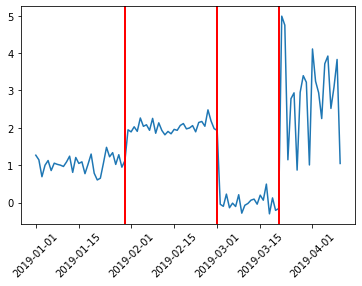

In [17]:
# plot the results
detector = CUSUMDetector(multi_cp_ts) # we are not really using this detector
detector.detector() # this call to detector is not being used for anything

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

## **1.2 BOCPDetector**

Bayesian Online Change Point Detection (BOCPD) is a method for detecting sudden changes in a time series that persist over time. Our implementation is faithful to ["Bayesian Online Changepoint Detection"](https://arxiv.org/abs/0710.3742) (Adams & McKay, 2007).  There are a coupple properties that distinguish BOCPD from the other change point detection methods supported in Kats:

* **Online Model:** This detection does not need to know the entire series apriori.  It only need to look a few steps ahead (specified by the `lag` parameter in the `detector` method) to make predictions, and it revises its predictions as new data arrives.  
* **Bayesian Model:** The user can specify prior beliefs about the probability of a changepoint (using the `changepoint_prior` paremeter in the `detector` method) and specify the the parameters of the underlying probability model that generates the time series (using the `model_parameters` parameter in the `detector` method).  Right now we support 3 diferent types of underlying probability models (specified using the `model` parameter in the `detector` method).

The basic idea of this detection method is uses Bayesian inference to decide if the next point is improbable.  This requires the user to specify (or use default values for) the **probability of a change point** and **underlying predictive model (UPM)** that generates the incoming data points in the time series.  Currently we support three different types of underlying models:
1. Normal Distribution (unknown mean, known variance)    
2. Trend Change Distribution    
3. Poisson Process Model    

The full set of parameters for the `detector` method in `BOCPDetector`, all of which are optional and have default values, are as follows: 

* **model**: This specifies the underlying probabilistic model (UPM) that generates the data within each segment.  Currently, allowed models are:
    * NORMAL_KNOWN_MODEL: Normal model with variance known. Use this to find level shifts in normally distributed data.
    * TREND_CHANGE_MODEL : This model assumes each segment is generated from ordinary linear regression. Use this model to understand changes in slope, or trend in time series.
    * POISSON_PROCESS_MODEL: This assumes a Poisson generative model. Use this for count data, where most of the values are close to zero.

* **model_parameters**: Model Parameters correspond to specific parameters for a specific model. They are defined in the NormalKnownParameters, TrendChangeParameters, PoissonModelParameters classes.

* **lag**: integer referring to the lag in reporting the changepoint. We report the changepoint after seeing "lag" number of data points. Higher lag gives greater certainty that this is indeed a changepoint. Lower lag will detect the changepoint faster. This is the trade-off.

* **changepoint_prior**: This is a Bayesian algorithm. Hence, this parameter specifies the prior belief on the probability that a given point is a changepoint. For example, if you believe 10% of your data will be a changepoint, you can set this to 0.1.

* **threshold**: We report the probability of observing the changepoint at each instant. The actual changepoints are obtained by denoting the points above this threshold to be a changepoint.

* **debug**: This surfaces additional information, such as the plots of predicted means and variances, which allows the user to see debug why changepoints were not properly detected.

**Note:** When using the normal distribution for a UPM, there are two ways to pick the prior parameters:      
* Use an empirical prior and estimate the parameters from the data (set attribute `empirical=True` in `NormalKnownParameters`)           
* Specify the mean and precision of the distribution 

### Basic Usage
Here we show the basic usage of `BOCPDetector` to detect mean shift.

We begin by simulating some data with some change points using the `Simulator` class.

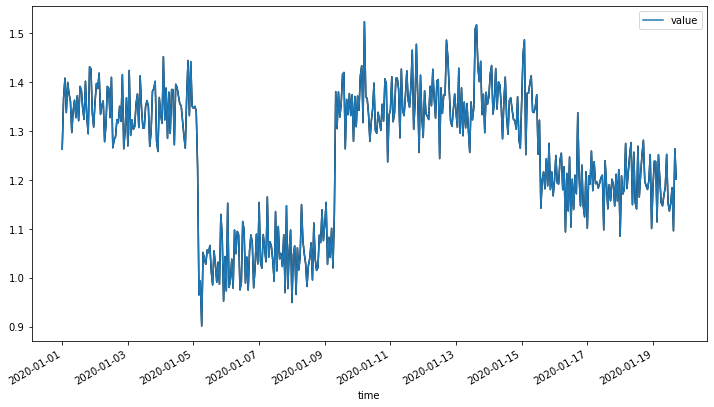

In [18]:
from kats.utils.simulator import Simulator

sim = Simulator(n=450, start='2020-01-01', freq='H')
ts_bocpd = sim.level_shift_sim(noise=0.05, seasonal_period=1)

# plot the simulated data
ts_bocpd.plot(cols=['value'])

Now we run BOCPD to find the change points in this simulated time series

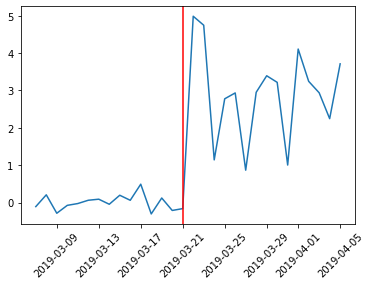

In [19]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(tsd)


changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL # this is the default choice
)

# Plot the data
plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

### Interpret the results

The return type of the `detector` method is `List[Tuple[TimeSeriesChangePoint, BOCPDMetadata]]`.  Let's see what that looks like for one of the change points detected above.

In [20]:
cp, meta = changepoints[0]
cp

TimeSeriesChangePoint(start_time: 2019-03-21T00:00:00.000000000, end_time: 2019-03-21T00:00:00.000000000, confidence: 0.9120017705261637)

The attributes of `BOCPDMetadata` are:
* **detector_type:** This will always be `kats.detectors.bocpd.BOCPDetector`
* **model:** The type of the underlying predictive model, either `NORMAL_KNOWN_MODEL`, `TREND_CHANGE_MODEL`, or `POISSON_PROCESS_MODEL`
* **ts_name**: the name of the time series


In [21]:
meta.__dict__

{'_detector_type': kats.detectors.bocpd.BOCPDetector,
 '_model': <BOCPDModelType.NORMAL_KNOWN_MODEL: 1>,
 '_ts_name': 'y'}

## **1.3 RobustStatDetector**

`RobustStatDetector`, like `CUSUMDetector`, is a change point detection algorithms that finds mean shifts.  It works as follows:
1. Smooth the time series using a moving average
2. Calculate the differences in the smoothed time series over a fixed number of points (specified by the `comparison_window` parameter in the `detector` method).
3. Calculate the z-scores and p-values for the differences calculated in step 2.  Return points where the p-value is smaller than a prescribed threshold (specified by the `p_value_cutoff` parameter in the dtector method`)

Unlike `CUSUMDetector`, `RobustStatDetector` can detect multiple change points in a single run.  After a basic example, we will show an example with multiple change points.

The full set of parameters for the `detector` method in `RobustStatDetector`, all of which are optional and have default values, are as follows: 
* **p_value_cutoff**: float, the p-value threshold to flag the change point; 
* **smoothing_window_size**: int, the length of the smoothing window;
* **comparison_window**: int, the step of the diff function, i.e. how many data points you want the algorithm look back to make the comparison.

### Basic Usage

We start by showing how to use `RobustStatDetector` using the same example we initially provided for `CUSUMDetector`.  The usage is straightforward.

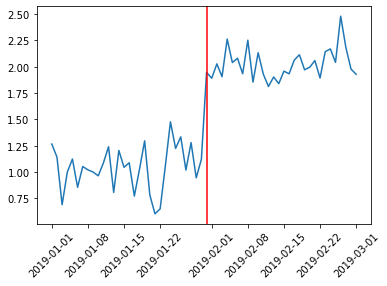

In [22]:
# import package
from kats.detectors.robust_stat_detection import RobustStatDetector

tsd = TimeSeriesData(df_increase_decrease.loc[:,['time','increase']])
detector = RobustStatDetector(tsd)
change_points = detector.detector()

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

The return type of the `detector` method is `List[Tuple[TimeSeriesChangePoint, RobustStatMetadata]]`.  Let's see what that looks like the change point detected above.

In [23]:
change_point, metadata = change_points[0]
change_point

TimeSeriesChangePoint(start_time: 2019-01-31T00:00:00.000000000, end_time: 2019-01-31T00:00:00.000000000, confidence: 0.9932728251020368)

The attributes of `RobustStatMetadata` are:
* **metric:** The raw value of the metric at the time of the change point  
* **index:** The index of the change point

In [24]:
metadata.__dict__

{'_metric': -0.32345014754902635, '_index': 30}

### Multiple Changepoints
The `RobustStatDetector` can detect multiple change points in one time series by one run. But one cautious here is that the algorithm will use the full time series to compute the z-score, which means it might affect the results negatively, e.g. it might not be able to detect a smaller change when there is a bigger change in the time series.

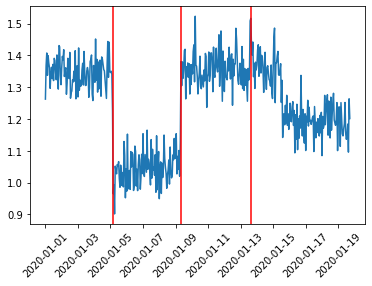

In [25]:
ts_bocpd = TimeSeriesData(ts_bocpd.to_dataframe())
detector = RobustStatDetector(ts_bocpd)
changepoints = detector.detector(p_value_cutoff = 5e-3, comparison_window=2)

# plot the results
plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

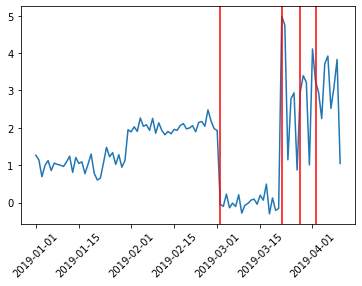

In [26]:
tsd = TimeSeriesData(df_multi_cps)
detector = RobustStatDetector(tsd)
# even setting the p_value to be 0.1 it cannot detect the first change point, while there are already many FPs in the results
changepoints = detector.detector(p_value_cutoff = 1e-1, comparison_window=2)

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

To avoid this we can again use the same way in `CUSUMDetector` to detect multiple change points by cutting the long time sereis into several different shorter sections.

# 2. Outlier Detection
Outliers in Time Series can cause a lot of issues in downstream processing. Therefore, removing outliers is important in any time series analysis. In Kats, we have three algorithms detecting outliers, one for univariate time series, one for multi-variate time series and one for detecting irregular daily patterns.

## **2.1 OutlierDetector**
We provide the `OutlierDetector` module to detect outliers in time series. Since outliers can cause so many problems in downstream processing, it is important to be able to detect them. `OutlierDetector` also provides functionality to handle or remove outliers once they are found.

Our outlier detection algorithm works as follows:
* We do a [seasonal decomposition](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) of the input time series, with additive or multiplicative decomposition as specified (default is additive)
* We generate a residual time series by either removing only trend or both trend and seasonality if the seasonality is strong.
* We detect points in the residual which are outside 3 times the inter quartile range. This multiplier can be tuned using the `iqr_mult` parameter in `OutlierDetector`.

Here are the parameters when initializing `OutlierDetector`:
* **data**: `TimeSeriesData` object with the time series
* **decomp**: `additive` or 'multiplicative' (default is additive)
* **iqr_mult**: `float`, multiplier on inter quartile range is used to classify outliers (default is 3)

Here we recap the example from the Kats 101 Tutorial of how to use `OutlierDetector` with the `air_passengers` data set.  Our example manually inserts outliers into the `air_passengers` data set and uses `OutlierDetector` to find them.

In [27]:
# load the air_passenger data set
air_passengers_outlier_df = pd.read_csv("../kats/data/air_passengers.csv")
air_passengers_outlier_df.columns = ["time", "value"]

# manually add outlier on the date of '1950-12-01'
air_passengers_outlier_df.loc[air_passengers_outlier_df.time == '1950-12-01','value']*=5
# manually add outlier on the date of '1959-12-01'
air_passengers_outlier_df.loc[air_passengers_outlier_df.time == '1959-12-01', 'value']*=4

# transform the outlier data into `TimeSeriesData` Object
air_passengers_outlier_ts = TimeSeriesData(air_passengers_outlier_df)

Now we can import and call `OutlierDetector` on `air_passengers_outlier_ts`

In [28]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(air_passengers_outlier_ts, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

Here we look at the outliers that the algorithum found.

In [29]:
ts_outlierDetection.outliers[0]

[Timestamp('1950-12-01 00:00:00'),
 Timestamp('1959-11-01 00:00:00'),
 Timestamp('1959-12-01 00:00:00')]

After detecting the outlier, we can now easily removal them from the data. Here we will explore two options: 
- **No Interpolation**: outlier data points will be replaced with **NaN** values
- **With Interpolation**: outlier data points will be replaced with **linear interploation** values

In [30]:
air_passengers_ts_outliers_removed = ts_outlierDetection.remover(interpolate = False) # No interpolation
air_passengers_ts_outliers_interpolated = ts_outlierDetection.remover(interpolate = True) # With interpolation

Here we visualize the difference between these two approaches to removing outliers.

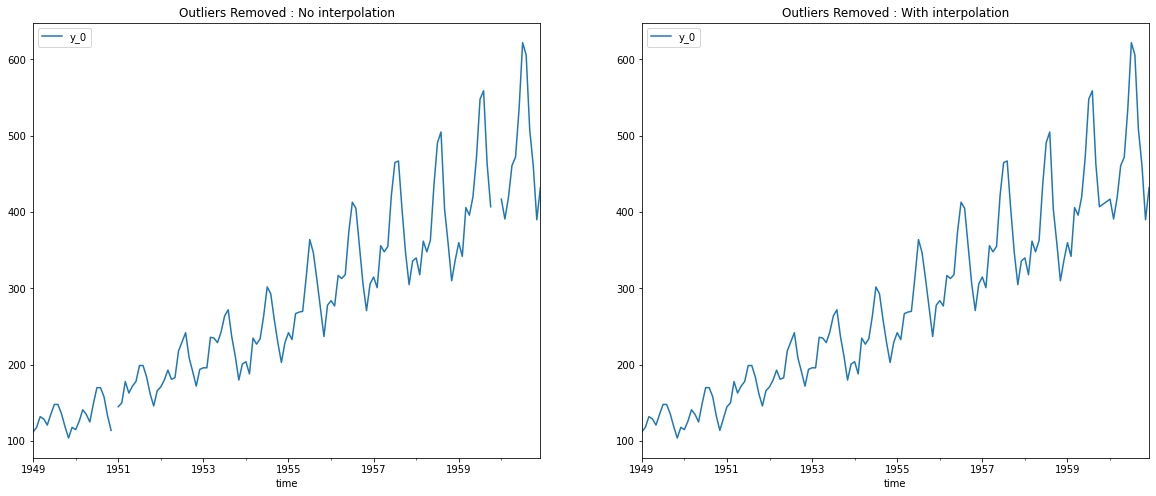

In [31]:
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2)

air_passengers_ts_outliers_removed.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[0])
ax[0].set_title("Outliers Removed : No interpolation")
air_passengers_ts_outliers_interpolated.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[1])
ax[1].set_title("Outliers Removed : With interpolation")
plt.show()

## **2.2 MultivariateAnomalyDetector**
This anomaly detection method is useful to detect anomalies across multiple time series. Anomalies are detected based on deviations from the predicted steady state behavior. The steady state behavior of a system of metrics is predicted by modeling the linear interdependencies between time-series using a Vector Autoregression (VAR) model. 

This approach is especially suited for detecting multivariate anomalies - small anomalies but persistent across a large number of time series.

In addition to identifying an anomalous event, this method has useful utilities to flag specific time series that were affected for a high level root cause analysis. For more details about the approach, please refer to this note.

Here are the attributes when initializing `MultivariateAnomalyDetector`:
* **data**: TimeSeriesData - Note that data should be deseasonalized and detrended prior to detection
* **params**: `VARParams` class initiated with appropriate parameters for the VAR model training
* **training_days**: Initial number of days (can be a fraction) to use for training the model. 

Here are the attributes for the `VARParams` class:
* **maxlags**: Maximum number of lags to check for order selection (defaults is 12)
* **method**: Estimation method to use (defaults is ordinary least squares (OLS))
* **ic**: Information criterion to use for VAR order selection (defaults to None)
* **trend**: 
    * “c” - add constant (Default), 
    * “ct” - constant and trend, 
    * “ctt” - constant, linear and quadratic trend,  
    * “n”/“nc” - no constant, no trend

### Basic usage

In [32]:
from kats.detectors.outlier import MultivariateAnomalyDetector, MultivariateAnomalyDetectorType
from kats.models.var import VARParams
from kats.models.bayesian_var import BayesianVARParams

import warnings
warnings.simplefilter(action='ignore')

In [33]:
multivariate_anomaly_simulated_data_df = pd.read_csv("../kats/data/multivariate_anomaly_simulated_data.csv")
TSData_multi = TimeSeriesData(multivariate_anomaly_simulated_data_df)

In [34]:
np.random.seed(10)

params = VARParams(maxlags=2)
d = MultivariateAnomalyDetector(TSData_multi, params, training_days=60)
anomaly_score_df = d.detector()

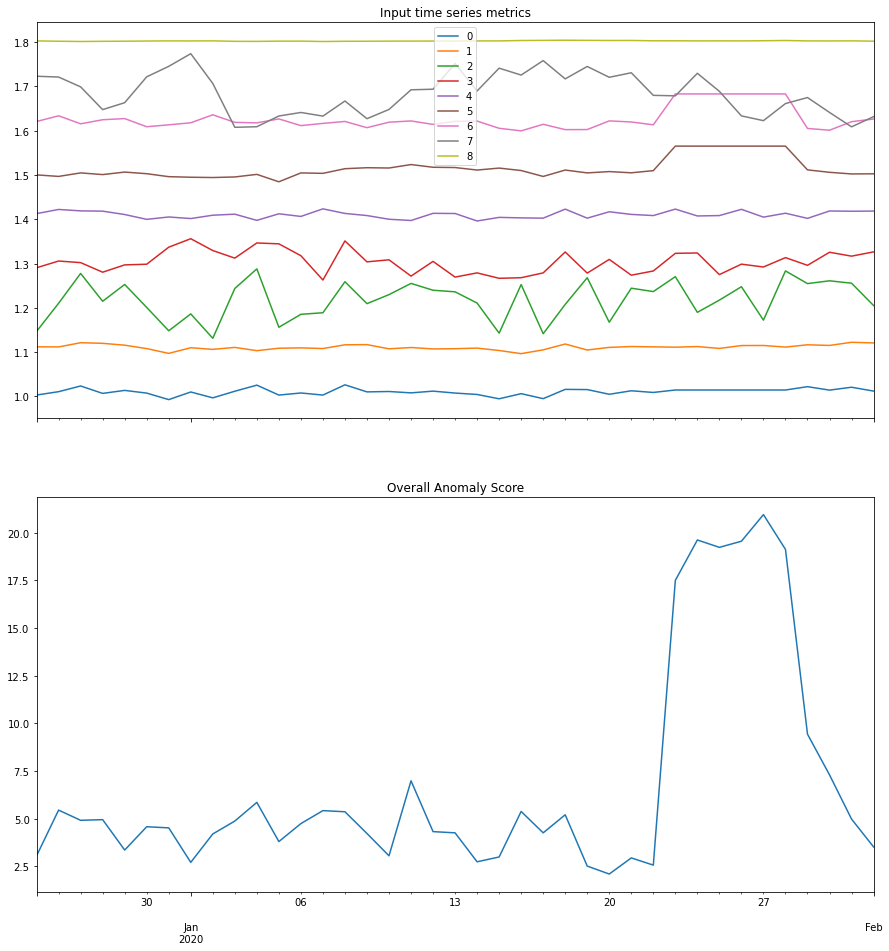

In [35]:
d.plot()

In [36]:
alpha = 0.05
anomalies = d.get_anomaly_timepoints(alpha)
d.get_anomalous_metrics(anomalies[0], top_k=3)

,metric,anomaly_score
0,5,12.757618
1,6,9.249919
2,4,2.511899


# 3. Trend detection
Trend detection tries to identify significant and prolonged changes in a time series.  Rather than identifying change points, trend detection identifies windows of gradual and prolonged change.

`MKDetector` is the trend detection algorithm that we include in Kats, which is based on the non-parametric Mann-Kendall (MK) Test.  What the `MKDetector` essentially does is apply a MK to a window of fied size (specified by the `window_size` argument in the `detector` method) and return the start point of each window for which this test is statistically significant.  Trend windows are detected based on the monotonicity of the increases or decreases in the time series in the window, not the magnitude of the change in the value of the time series over the window.  

The test statistic for the MK test is called the Kendall's Tau Coefficient, which ranges from -1 to 1.  
* A Tau coefficient of -1 indicates a perfectly monotonic decline
* A Tau coefficient of 1 indicates a perfectly monotonic increase
* A coefficient of 0 indicates there is no directional trend

The MK Test converts the Tau Coefficient (along with the value of `window_size`) to a p-value, and we return change points for which the p-value is smaller than `alpha` (0.05 by default).  For additional control of the intensity of the trends we return, we can use the `threshold` attribute in `MKDetector` to put an absolute lower-bound threshold on the value of the Tau Coeffficients for trend windows that are returned. 


These are the parameters to use when initializing `MKDetector`:
* **data**: TimeSeriesData, this is time series data at one-day granularity. This time series can be either univariate or multivariate. We require more than training_days points in each time series.
* **threshold**: float, threshold for trend intensity; higher threshold gives trend with high intensity (0.8 by default)
* **alpha**: float, significance level (0.05 by default)

The full set of parameters for the `detector` method in `MKDetector`, all of which are optional and have default values, are as follows: 
* **window_size**: int, the number of look back days for checking trend persistence (20 days by default)
* **training_days**: int, the number of days for time series smoothing; should be greater or equal to window_size (None by default). If training_days is None, we will perform trend detection on the whole time series; otherwise, we will perform trend detection only for the anchor point using the previous training_days data.

* **direction**: string, the direction of the trend to be detected, choose from {"down", "up", "both"}  ("both" by default)

* **freq**: str, the type of seasonality shown in the time series, choose from {'weekly','monthly','yearly'} (None by default)

### Basic Usage

We begin by simulating some data with weekly seasonality using the `Simulator` class.  

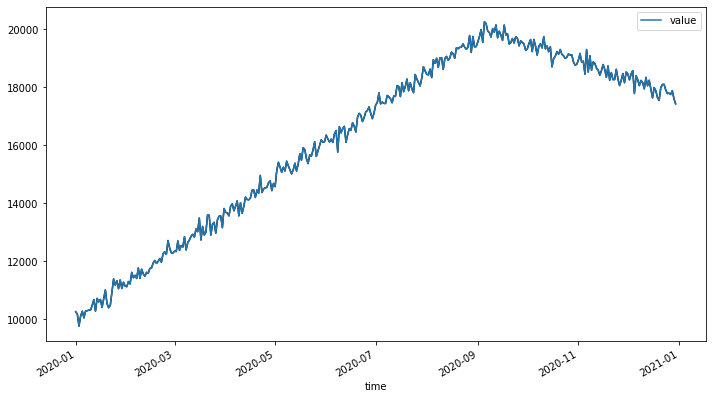

In [37]:
from kats.utils.simulator import Simulator

sim = Simulator(n=365, start='2020-01-01', freq='D')
tsd = sim.trend_shift_sim(noise=200, seasonal_period=7, seasonal_magnitude=0.007,
                              cp_arr=[250], intercept = 10000, trend_arr=[40,-20])

# plot the simulated data
tsd.plot(cols=['value'])

Now we can use the `MKDetector` detector to look for a downward trend.  Because the input data has weekly seasonality, will want to smooth the time series using a 7-day rolling average prior to running the detection algorithm.  We can do this by `freq = 'weekly'` in the `detector` method. 

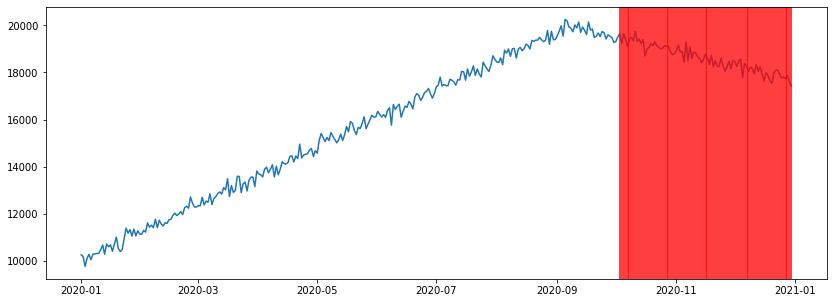

In [38]:
from kats.detectors.trend_mk import MKDetector

detector = MKDetector(data=tsd, threshold=.8)
# run detector
detected_time_points = detector.detector(direction='down', window_size=20, freq='weekly')
# plot the results
detector.plot(detected_time_points)

### Interpret the results
The return type of the `detector` method is `List[Tuple[TimeSeriesChangePoint, MKMetadata]]`.  Each `TimeSeriesChangePoint` returned is the beginning of an increasing or decreasing trend window of duration `window_size`.  In our example, we are looking for decreasing trend windows of length 20.

In [39]:
cp, meta = detected_time_points[0]
cp

TimeSeriesChangePoint(start_time: 2020-10-03 00:00:00, end_time: 2020-10-03 00:00:00, confidence: 0.9999998244557637)

The attributes of `MKMetadata` are:
* **detector_type:** Always `kats.detectors.trend_mk.MKDetector`     
* **is_multivariate:** Whether this is a change point for a multivariate time seires
* **trend_direction:** Direction of the trend, either 'increasing' or 'decreasing'
* **Tau:** kendall's Tau value for the change point.  This is a float for univariate time series and a dictionary for multivariate time series

In [40]:
meta.__dict__

{'_detector_type': kats.detectors.trend_mk.MKDetector,
 '_is_multivariate': False,
 '_trend_direction': 'decreasing',
 '_Tau': -0.8526315789473684}